# Breast Cancer Proteomes
### Dividing cancer patients into separate sub-classes

The data for this project was acquired to assess how the mutations in the DNA are affecting the protein expression landscape in breast cancer. Genes in our DNA are first transcribed into RNA molecules which are then translated into proteins. Changing the information content of DNA has an impact on the behavior of the proteome (the entire complement of proteins that are produced), and proteins are the main functional unit of cells, taking care of cell division, DNA repair, enzymatic reactions and signaling etc. The original study used this data to perform K-means clustering on the protein data to divide the breast cancer patients into sub-types, each having unique protein expression signature. They found that the best clustering was achieved using 3 clusters (original PAM50 gene set yields four different subtypes using RNA data). 

### Research Proposal:
The data here presents an interesting opportunity to perhaps take a step in improving on the existing methods in breast cancer treatment. Currently, the PAM50 panel of genes is used to classify breast cancers into subtypes which essentially guide treatment by telling us how likely a tumor is to metastasize. A higher likelihood of metastasis will require more aggressive forms of treatment. The data currently used for these screenings is mRNA, the precursor to proteins which are the functional units of all cells. However, looking at the final product, the protein, instead of the mRNA could provide new insights that ultimately improve treatment and patient outcomes. In the data here we have protein expression levels for over 12,000 different proteins across 80 different patients. I will perform clustering methods on the entire set, as well as on a subset containg just proteins from the PAM50 genes, to identify the optimal number of sub-classes of patients. In addition, I will get to compare how similar clustering is based off PAM50 proteins as compared with using mRNA screening. The goal from being able to perform these methods on data such as this will ultimately be to identify new sub-classes of breast cancer patients which could lead to a more targeted and more individualized treatment which is ultimately more effective.  

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sklearn.manifold import TSNE
import umap

In [59]:
# Load data
expression = pd.read_csv(r'C:\Users\mike1\Documents\Thinkful\77_cancer_proteomes_CPTAC_itraq.csv', header = 0, index_col = 0)
    ## contains the expression level for over 12,000 proteins screened for in 80 breast cancer patients
clinical = pd.read_csv(r'C:\Users\mike1\Documents\Thinkful\clinical_data_breast_cancer.csv', header = 0, index_col = 0)
    ## contains clinical information on breast cancer patients that were screened, including the cluster numbers from the original study
proteins = pd.read_csv(r'C:\Users\mike1\Documents\Thinkful\PAM50_proteins.csv', header = 0, index_col = 0)
    ## contains info on the PAM50 genes that are normally screened for

## Data Exploration: Protein Expression Data

In [3]:
expression.head()

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [4]:
expression.describe()

,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
count,11334.000000,11335.000000,11334.000000,12024.000000,12025.000000,11833.000000,11833.000000,11732.000000,11732.000000,11276.000000,...,11477.000000,10324.000000,10324.000000,10324.000000,9694.000000,9693.000000,9697.000000,10912.000000,10885.000000,10913.000000
mean,0.133079,0.128822,-0.440764,-0.729233,-0.039436,0.115353,-0.618354,-0.305320,-0.021228,0.077247,...,-0.677085,-0.103215,-0.021222,-0.100912,0.488502,-0.368762,-0.050669,0.069555,-0.298170,0.310974
std,1.734231,1.579845,1.634930,2.422452,1.353505,1.652918,2.281818,1.567687,1.651917,1.749695,...,2.018394,1.570606,1.656519,1.628017,1.658080,1.453737,1.716237,1.950822,1.307027,1.706759
min,-12.466750,-13.156553,-9.911008,-24.553794,-15.004199,-12.956961,-16.640848,-18.710032,-14.711526,-13.441463,...,-12.497832,-12.152747,-11.874381,-11.128835,-8.772601,-10.427946,-12.967849,-12.609296,-9.058864,-6.328154
25%,-0.656376,-0.583835,-1.330525,-1.266591,-0.671173,-0.679944,-1.278707,-0.991299,-0.718023,-0.728075,...,-1.731881,-0.815820,-0.740905,-0.805968,-0.497485,-1.063180,-0.934818,-0.867155,-1.056363,-0.652571
50%,0.078915,0.116448,-0.318937,-0.296430,0.024160,0.088055,-0.157218,-0.231885,0.037039,0.045209,...,-0.444306,-0.056808,0.023619,-0.037659,0.314206,-0.204129,-0.079784,0.052313,-0.191285,0.137007
75%,0.905641,0.853163,0.489641,0.449590,0.719492,0.929197,0.670727,0.483663,0.750830,0.862472,...,0.500677,0.657177,0.800701,0.714075,1.276655,0.521043,0.757374,1.009641,0.574868,1.059485
max,17.623036,12.677023,8.289261,11.790434,6.925004,10.602330,10.079191,8.804312,9.548006,13.066445,...,8.839935,10.694780,11.309371,12.638208,11.164262,7.886564,11.521261,16.183559,6.435721,10.497291


Top 10 most common proteins screened:
 NADH dehydrogenase                                       41
poly                                                      7
isocitrate dehydrogenase                                  6
PREDICTED: peptidyl-prolyl cis-trans isomerase A-like     4
dimethylaniline monooxygenase                             4
succinyl-CoA ligase                                       3
PREDICTED: serine/threonine-protein kinase SMG1-like      3
PREDICTED: myomegalin-like isoform 2                      3
glutamine--fructose-6-phosphate aminotransferase          2
PREDICTED: HEAT repeat-containing protein 7B1             2
Name: gene_name, dtype: int64


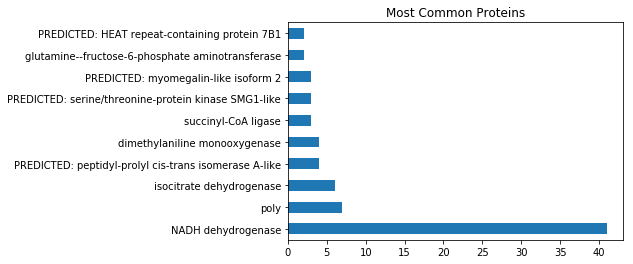

In [5]:
# Find the 10 most common proteins 
print("Top 10 most common proteins screened:\n", expression['gene_name'].value_counts().nlargest(10))

# Plot results 
expression['gene_name'].value_counts().nlargest(10).plot.barh(title = "Most Common Proteins")

Exploring the expression level data, there are a few interesting findings here. First, NADH dehydrogenase was by far the most commonly screened for protein and it could be the case that there are many different isoforms of this protein. It can also be noted that there is a noticeable difference in the descriptive statistics of the total protein expression levels amongst the patients. It is hard to interpret exactly what this means and if there is any clinical utility to this finding, but is interesting to note nonetheless. 

## Data Exploration: Clinical Data

In [6]:
clinical.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,...,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2


In [7]:
clinical.describe()

,Age at Initial Pathologic Diagnosis,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
count,105.000000,105.000000,11.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,58.685714,788.390476,1254.454545,0.104762,817.647619,-4.885714,-7.180952,4.000000,3.342857,2.590476,2.742857,1.980952,2.352381
std,13.066630,645.283040,678.050642,0.307715,672.026613,3.558074,5.022605,1.593255,1.406226,1.342323,1.074428,0.970537,1.091761
min,30.000000,0.000000,160.000000,0.000000,0.000000,-12.000000,-13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,49.000000,240.000000,947.500000,0.000000,240.000000,-6.000000,-12.000000,3.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,58.000000,643.000000,1364.000000,0.000000,665.000000,-5.000000,-6.000000,4.000000,4.000000,3.000000,3.000000,2.000000,2.000000
75%,67.000000,1288.000000,1627.500000,0.000000,1305.000000,-3.000000,-2.000000,5.000000,4.000000,3.000000,4.000000,3.000000,3.000000
max,88.000000,2850.000000,2483.000000,1.000000,2850.000000,0.000000,0.000000,7.000000,5.000000,5.000000,4.000000,4.000000,5.000000


In [8]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, TCGA-A2-A0T2 to TCGA-E2-A15A
Data columns (total 29 columns):
Gender                                 105 non-null object
Age at Initial Pathologic Diagnosis    105 non-null int64
ER Status                              105 non-null object
PR Status                              105 non-null object
HER2 Final Status                      105 non-null object
Tumor                                  105 non-null object
Tumor--T1 Coded                        105 non-null object
Node                                   105 non-null object
Node-Coded                             105 non-null object
Metastasis                             105 non-null object
Metastasis-Coded                       105 non-null object
AJCC Stage                             105 non-null object
Converted Stage                        105 non-null object
Survival Data Form                     105 non-null object
Vital Status                           105 non-null obj

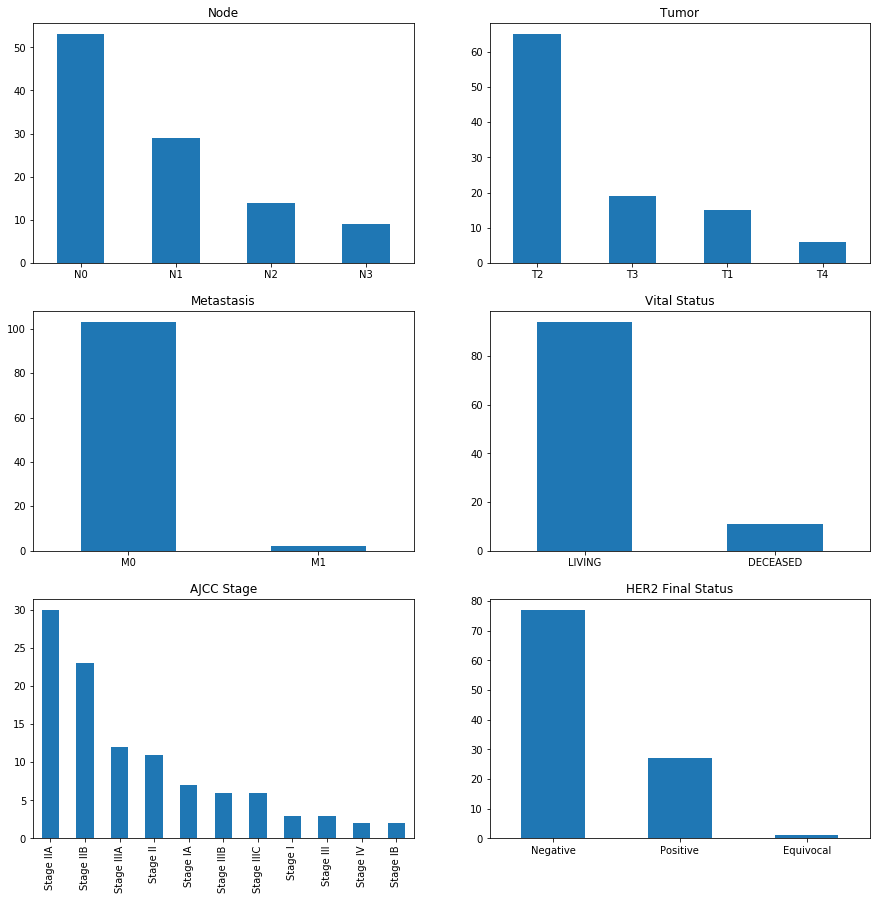

In [9]:
plt.figure(figsize = (15, 15))

plt.subplot(3, 2, 1)
clinical['Node'].value_counts().plot(kind = "bar", rot = 0, title = "Node")

plt.subplot(3, 2, 2)
clinical['Tumor'].value_counts().plot(kind = "bar", rot = 0, title = "Tumor")

plt.subplot(3, 2, 3)
clinical['Metastasis'].value_counts().plot(kind = "bar", rot = 0, title = "Metastasis")

plt.subplot(3, 2, 4)
clinical['Vital Status'].value_counts().plot(kind = "bar", rot = 0, title = "Vital Status")

plt.subplot(3, 2, 5)
clinical['AJCC Stage'].value_counts().plot(kind = "bar", title = "AJCC Stage")

plt.subplot(3, 2, 6)
clinical['HER2 Final Status'].value_counts().plot(kind = "bar", rot = 0, title = "HER2 Final Status")

plt.show()

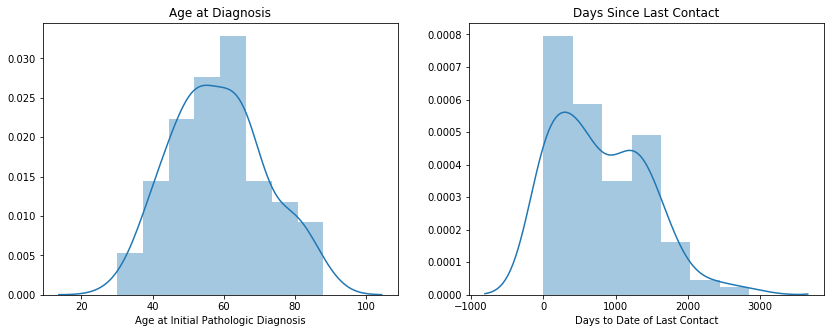

In [60]:
plt.figure(figsize = (14, 5))

plt.subplot(1, 2, 1)
sns.distplot(clinical['Age at Initial Pathologic Diagnosis'])
plt.title("Age at Diagnosis")

plt.subplot(1, 2, 2)
sns.distplot(clinical['Days to Date of Last Contact'])
plt.title("Days Since Last Contact")

plt.show()

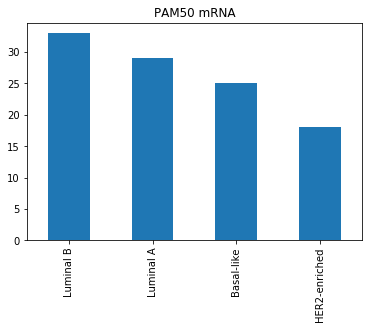

In [11]:
# This will be our target to compare against
clinical['PAM50 mRNA'].value_counts().plot.bar(title = "PAM50 mRNA")

Exploring the clinical data we get a good feeling for the overall health status of the patients but the most important thing to consider for this project is the PAM50 mRNA data. This will end up being the target variable that we will compare against as mentioned previously. As we can see there are four outcomes so we would expect the clustering solutions to be optimized at four. 

## Data Exploration: PAM50 Protein Data

In [12]:
proteins.head()

,RefSeqProteinID,Species,Gene Name
GeneSymbol,,,
MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160


In [13]:
proteins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, MIA to UBE2T
Data columns (total 3 columns):
RefSeqProteinID    100 non-null object
Species            100 non-null object
Gene Name          100 non-null object
dtypes: object(3)
memory usage: 3.1+ KB


Top 10 most common proteins screened:
 Mdm2 p53 binding protein homolog (mouse)                                                      9
N-acetyltransferase 1 (arylamine N-acetyltransferase)                                         9
ubiquitin-conjugating enzyme E2C                                                              6
microtubule-associated protein tau                                                            6
estrogen receptor 1                                                                           4
epidermal growth factor receptor (erythroblastic leukemia viral (v-erb-b) oncogene homolog    4
baculoviral IAP repeat-containing 5                                                           3
exonuclease 1                                                                                 3
fibroblast growth factor receptor 4                                                           3
NUF2                                                                                          2
N

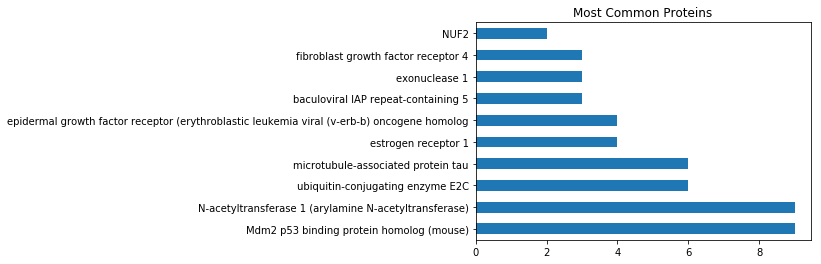

In [14]:
# Visualize the 20 most common proteins 
print("Top 10 most common proteins screened:\n", proteins['Gene Name'].value_counts().nlargest(10))

# Plot results -- top 10
proteins['Gene Name'].value_counts().nlargest(10).plot.barh(title = "Most Common Proteins")

The PAM50 data will be more so used as an index than anything else as it only contains the gene names and their corresponding RefSeq Identification tags. It is still interesting to see which proteins appear most frequently, and thus play a more prominent role in breast cancer. There is a p53 binding protein at the top of the list which almost seems to be expected as p53 is a hallmark of most cancers.  

## Setting Up Data for Unsupervised Learning:

Now that we've explored the three separate datasets, we need to combine and transform them a little to get ready for the clustering methods. Specifically, we need to transpose the data so that each protein is in a column and each row consists of a different patient. I will have one set with the entirety of the proteins and one set representing only the PAM50 proteins.  

In [15]:
## Drop unused information columns and healthy patients
expression.drop(['gene_symbol','gene_name'],axis=1,inplace=True)
  
## Change the protein data sample names to a format matching the clinical data set
expression.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
expression = expression.transpose()
 
## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in expression.index],:]
 
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = expression.merge(clinical,left_index=True,right_index=True)

## Dataframe consisting of all protein expression data
proteomes = merged.loc[:,[x for x in merged.columns if bool(re.search("NP_|XP_",x)) == True]]

## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
numerical_cols = [x for x in merged.columns if bool(re.search("NP_|XP_", x)) == True ]
processed_numerical = proteomes.loc[:, numerical_cols]
pam_50 = processed_numerical.columns.isin(proteins['RefSeqProteinID'])

# Dataframe consisting of only protein data from PAM50 proteins
p50 = processed_numerical.iloc[:, pam_50]

## Data Cleaning

Initially looking at the data I found that there were a number of columns with a high percentage of missing values. In these datasets, missing values were evidence that the level of protein expression was too small to be picked up. As such I've decided to remove columns where greater than 55% of the values are missing. This dropped four columns from the PAM50 data (43 to 39) and around 1,000 columns from the complete proteomes data set. It's important to note that this could result in the dropping of important markers for some patients; however, since the goal here is to group based off a complement of different proteins I think this is the best solution. For the remaining missing values I will replace those with the median value from all other patients.   

In [16]:
# Drop columns with more than 55% of values as NaNs
limitPer = len(proteomes) * 0.55
proteomes = proteomes.dropna(thresh = limitPer, axis = 1)

In [17]:
# Drop columns with more than 55% of values as NaNs
limitPer = len(p50) * 0.55
p50 = p50.dropna(thresh = limitPer, axis = 1)

In [18]:
# Check for missing values
proteomes.isnull().sum()/proteomes.isnull().count()*100

NP_958782        0.00
NP_958785        0.00
NP_958786        0.00
NP_000436        0.00
NP_958781        0.00
NP_958780        0.00
NP_958783        0.00
NP_958784        0.00
NP_112598        0.00
NP_001611        0.00
NP_076965        0.00
NP_001367        0.00
NP_036222        0.00
NP_001138241     0.00
NP_001714        0.00
NP_002464        0.00
NP_001073936     0.00
NP_061198        0.00
NP_001074248     0.00
NP_001074419     0.00
NP_056009        0.00
NP_036355        0.00
NP_001155291     0.00
NP_002462        0.00
NP_000248        0.00
NP_036467        0.00
NP_004989        0.00
NP_001243024     0.00
NP_149043        0.00
NP_067047       20.00
                ...  
NP_066009       27.50
NP_653179        2.50
NP_068741       26.25
NP_002460       18.75
NP_115956       31.25
NP_006685       23.75
NP_001092808    16.25
NP_694948       23.75
NP_000610       12.50
NP_699178        3.75
NP_006140        7.50
NP_068835        3.75
NP_872308       37.50
NP_001129479    42.50
NP_612382 

In [19]:
# Check for missing values
p50.isnull().sum()/p50.isnull().count()*100

NP_057427        0.00
NP_002408        0.00
NP_000415        0.00
NP_000413        0.00
NP_000517        0.00
NP_004439        0.00
NP_005219        0.00
NP_058519        0.00
NP_058518        0.00
NP_001116539     0.00
NP_061155        0.00
NP_001035932     0.00
NP_077006        0.00
NP_000917        0.00
NP_065178        0.00
NP_006836        0.00
NP_006614        0.00
NP_001784        3.75
NP_006092        2.50
NP_001153651     0.00
NP_001159403     0.00
NP_000116        0.00
NP_004314        0.00
NP_060601        2.50
NP_005931        0.00
NP_003003        0.00
NP_113611        6.25
NP_002002       13.75
NP_004487        0.00
NP_008950        0.00
NP_114172        7.50
NP_001062        6.25
NP_057547        7.50
NP_054895        0.00
NP_001246       11.25
NP_055606       43.75
NP_036451       22.50
NP_000624       25.00
NP_001159       18.75
dtype: float64

In [20]:
# Replace remaining missing values in both data sets with median
for column in proteomes:
    proteomes.loc[:, column] = proteomes.loc[:, column].fillna(proteomes.loc[:, column].median())

for column in p50:
    p50.loc[:, column] = p50.loc[:, column].fillna(p50.loc[:, column].median())

## Data Exploration: Proteomes and PAM50 Data

In [21]:
proteomes.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_665813,NP_005279,NP_001165887,NP_001010893,NP_000871,NP_683762,NP_699174,NP_001193600,NP_003593,NP_001191293
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,-1.101926,0.837691,0.180132,-2.512556,1.078322,-2.222349,0.999326,-0.861266,0.187822,-2.577631
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,3.230994,-10.473833,1.561134,-0.517875,1.171943,-2.586905,-0.384818,0.919136,0.187822,-4.679219
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,-1.077235,-1.624510,0.663580,1.670618,1.078322,-2.401410,0.583405,-0.801685,3.802310,-1.123160
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,-0.504820,-11.959277,1.329574,-0.826889,1.078322,-6.918196,-2.585666,-4.966177,-0.474013,-10.337729
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,0.626081,-2.651380,3.713862,1.504016,4.449227,-3.812370,2.629575,1.451490,0.187822,-6.101005


In [22]:
p50.head()

,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,...,NP_008950,NP_114172,NP_001062,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_001159
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,2.549550,2.733226,0.896468,-1.292949,3.541400,3.177722,0.001309,-1.792547,-0.830502,2.516489
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,2.376105,2.781928,6.836827,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,3.487128
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,...,0.545453,-0.273546,1.460128,-1.410193,0.702364,-1.402538,0.001309,-0.210764,1.934688,0.798041
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,...,-2.179579,-3.311022,0.139319,0.018893,-1.574649,-4.515280,0.001309,-0.210764,2.049328,-0.266769
TCGA-A2-A0EX,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,...,-3.752341,-3.317125,-2.769353,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-3.046991


In [23]:
# Create a dictionary for pam50 columns 
list1 = p50[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
p50_dict = dict( zip( list1, list2))
print(p50_dict)

{'NP_057427': 1, 'NP_002408': 2, 'NP_000415': 3, 'NP_000413': 4, 'NP_000517': 5, 'NP_004439': 6, 'NP_005219': 7, 'NP_058519': 8, 'NP_058518': 9, 'NP_001116539': 10, 'NP_061155': 11, 'NP_001035932': 12, 'NP_077006': 13, 'NP_000917': 14, 'NP_065178': 15, 'NP_006836': 16, 'NP_006614': 17, 'NP_001784': 18, 'NP_006092': 19, 'NP_001153651': 20, 'NP_001159403': 21, 'NP_000116': 22, 'NP_004314': 23, 'NP_060601': 24, 'NP_005931': 25, 'NP_003003': 26, 'NP_113611': 27, 'NP_002002': 28, 'NP_004487': 29, 'NP_008950': 30, 'NP_114172': 31, 'NP_001062': 32, 'NP_057547': 33, 'NP_054895': 34, 'NP_001246': 35, 'NP_055606': 36, 'NP_036451': 37, 'NP_000624': 38, 'NP_001159': 39}


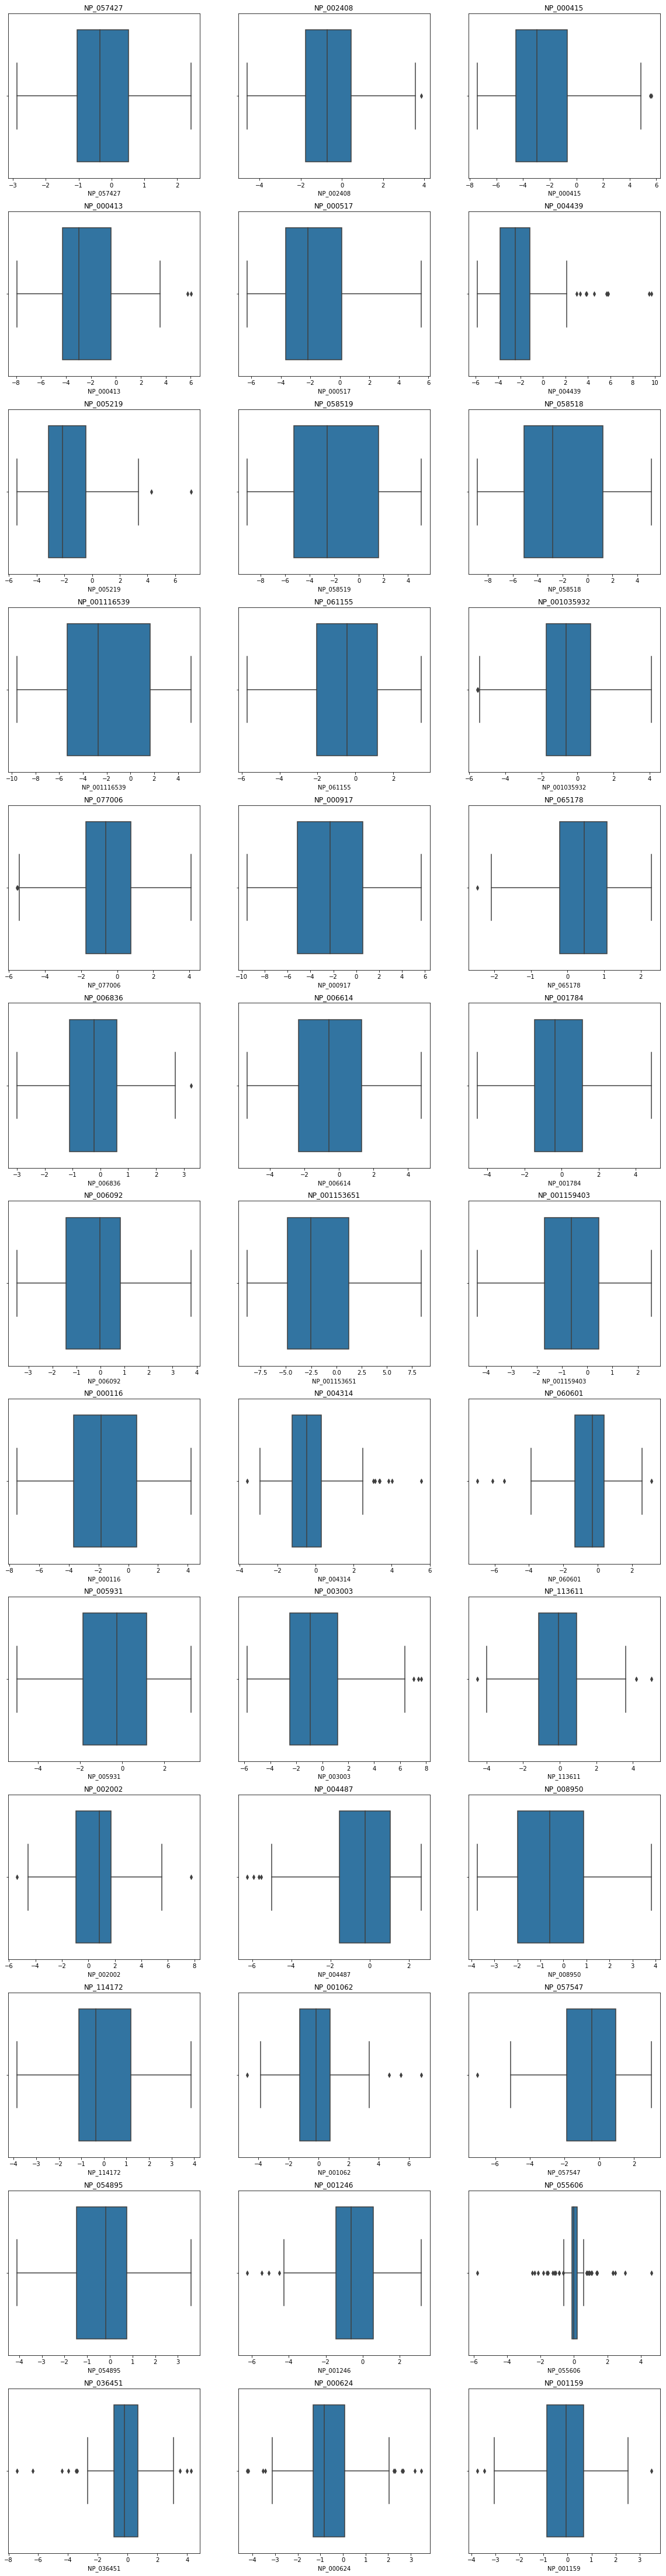

In [24]:
# Visualizing the distribution of the pam50 proteins
plt.figure(figsize=(20, 80))

for variable, i in p50_dict.items():
                     plt.subplot(13, 3, i)
                     sns.boxplot(p50[variable])
                     plt.title(variable)

plt.show()

I chose to create boxplots to try to gain a little insight into the levels of expression for the PAM50 proteins. The first thing to notice is that all of the proteins appear to be pretty normally distributed. It could be interesting to explore some of the proteins where there are outliers to see if there is any clinical significance in the patients who are expressing the abnormal levels. Also, it should be noted the different scales for some of the proteins here. Perhaps a wider range in expression could indicate stronger markers.   

We now have a a cleaned up data frame with each row representing a different patient and each column representing a different protein and its expression level. Now we can perform unsupervised learning to cluster the patients together based off their protein expression levels. But first we'll perform dimensionality reduction techniques on the data.  

## Apply dimensionality reduction techniques to visualize the observations

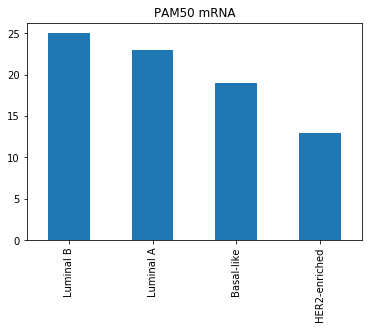

In [25]:
# This will be our target to compare against
merged['PAM50 mRNA'].value_counts().plot.bar(title = "PAM50 mRNA")
    ##note the smaller counts here as some patients did not have protein expression data

In [26]:
# Making the target numerical 
merged.replace(['Luminal B', 'Luminal A', 'Basal-like', 'HER2-enriched'],
                 [1, 2, 3, 4], inplace = True)

In [27]:
# Target and data for the entire protein expression set
X = proteomes
y = merged['PAM50 mRNA']

# Normalize
X_std = StandardScaler().fit_transform(X)

In [28]:
# Data for the PAM50 protein set
X_p50 = p50

# Normalize
X_std_p50 = StandardScaler().fit_transform(X_p50)

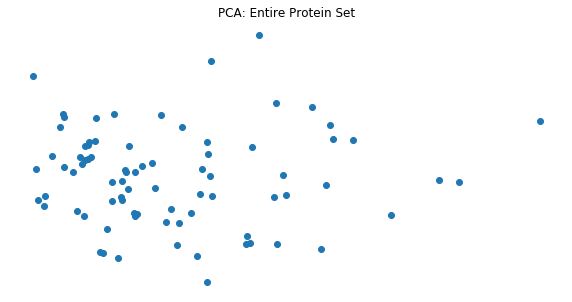

In [29]:
# visualize pca
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("PCA: Entire Protein Set")
plt.show()

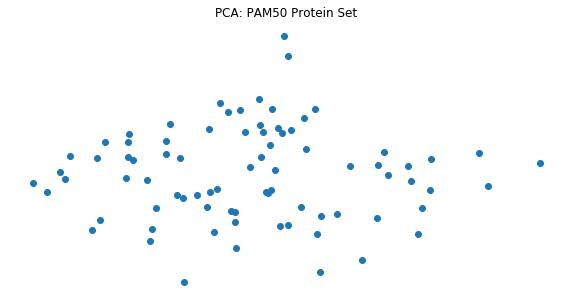

In [30]:
# visualize pca
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_std_p50)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("PCA: PAM50 Protein Set")
plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.016s...
[t-SNE] Computed neighbors for 80 samples in 0.156s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 34.058905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.518982
[t-SNE] KL divergence after 300 iterations: 2.182054


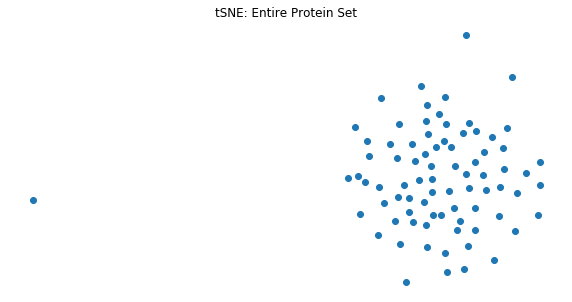

In [31]:
# visualize t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("tSNE: Entire Protein Set")
plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.000s...
[t-SNE] Computed neighbors for 80 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 2.404652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.467300
[t-SNE] KL divergence after 300 iterations: 1.592734


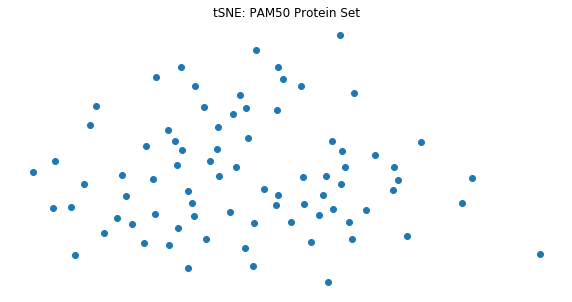

In [32]:
# visualize t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X_std_p50)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("tSNE: PAM50 Protein Set")
plt.show()

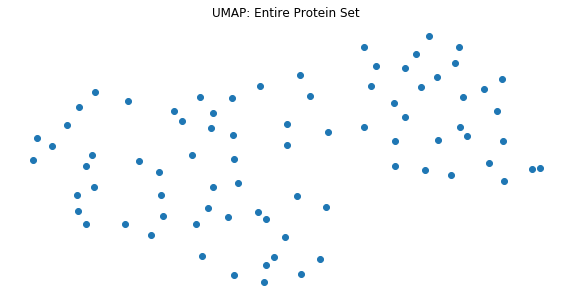

In [33]:
# visualize UMAP
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("UMAP: Entire Protein Set")
plt.show()

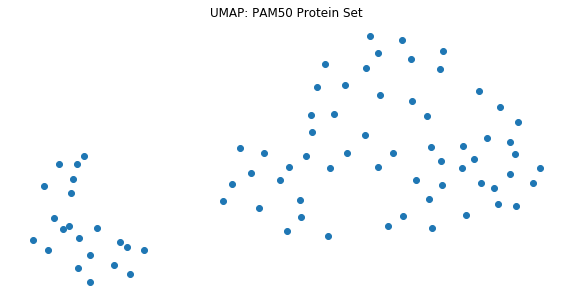

In [34]:
# visualize UMAP
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_std_p50)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("UMAP: PAM50 Protein Set")
plt.show()

Applying the dimensionality reductions using PCA, t-SNE, and UMAP they all did a really good job at separating out the patients based off their protein expression levels. UMAP and t-SNE seemed to have separated the patients more clearly than PCA and since we were only dealing with 80 rows, all these methods were very fast so speed was not an issue. It's pretty interesting that there is enough of a difference in the expression levels for all patients that we can visualize each patient as being rather distinguishable from the next. The UMAP method for the PAM50 data was the only technique where we can see real separation and the result is two distinct clusters. Next, we'll look at three different clustering methods and see how well we can group patients together based off their proteomes.  

## Apply clustering techniques to group together similar observations

### K-means clustering

In [35]:
## Check which number of clusters works best
n_clusters = [2, 3, 4, 5, 6, 7, 10, 20]

In [36]:
def compare_k_means(k_list, data):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k, random_state=123)
        clusterer.fit(data)
        ##
        print("Adjusted Rand Index for k == {}: {}".format(k, metrics.adjusted_rand_score(y, clusterer.labels_)))
        print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(data, clusterer.labels_)))
        print("\n")

In [37]:
# Evaluate k-means for the proteomes data
compare_k_means(n_clusters, proteomes)

Adjusted Rand Index for k == 2: 0.005792694877006699
Silhouette Coefficient for k == 2: 0.13230895827770653


Adjusted Rand Index for k == 3: 0.15607536047890963
Silhouette Coefficient for k == 3: 0.05625699257102139


Adjusted Rand Index for k == 4: 0.07762068649673577
Silhouette Coefficient for k == 4: 0.048505315120192974


Adjusted Rand Index for k == 5: 0.2054949322186978
Silhouette Coefficient for k == 5: 0.038260445883297835


Adjusted Rand Index for k == 6: 0.0407200863486842
Silhouette Coefficient for k == 6: 0.04840462057172919


Adjusted Rand Index for k == 7: 0.08473703532418245
Silhouette Coefficient for k == 7: 0.044426779051905334


Adjusted Rand Index for k == 10: 0.07082707361429588
Silhouette Coefficient for k == 10: 0.039752855267870216


Adjusted Rand Index for k == 20: 0.058876936198310734
Silhouette Coefficient for k == 20: 0.0466050406198408




In [38]:
# Evaluate k-means for the PAM50 data
compare_k_means(n_clusters, p50)

Adjusted Rand Index for k == 2: 0.22133865889109447
Silhouette Coefficient for k == 2: 0.21900293006603783


Adjusted Rand Index for k == 3: 0.38346002224083564
Silhouette Coefficient for k == 3: 0.18168592762809505


Adjusted Rand Index for k == 4: 0.3311310672200092
Silhouette Coefficient for k == 4: 0.14747757087863472


Adjusted Rand Index for k == 5: 0.42020668526224336
Silhouette Coefficient for k == 5: 0.1486433832889508


Adjusted Rand Index for k == 6: 0.43028056481266963
Silhouette Coefficient for k == 6: 0.14225014274048872


Adjusted Rand Index for k == 7: 0.34279288953400827
Silhouette Coefficient for k == 7: 0.11619826850437351


Adjusted Rand Index for k == 10: 0.2463865369306781
Silhouette Coefficient for k == 10: 0.11751018725001158


Adjusted Rand Index for k == 20: 0.13650744211130433
Silhouette Coefficient for k == 20: 0.0841078331883008




Looking at the k-means results, for the entire protein set the scores were pretty low for both the ARI and silhouette metrics. The optimal solution was at k=5. For the PAM50 set, the scores were much better overall and the optimal seems to be at either k=5 or k=6 which had very similar scores. 

### Hierarchical clustering

In [39]:
def compare_agg_clusters_complete(k_list, data):
    print('LINKAGE: COMPLETE\n')
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = AgglomerativeClustering(linkage='complete',
                                      affinity = 'cosine',
                                      n_clusters = k)
        clusterer.fit(data)
        
        print("Adjusted Rand Index for k == {}: {}".format(k, metrics.adjusted_rand_score(y, clusterer.labels_)))
        print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(data, clusterer.labels_)))
        print('\n')

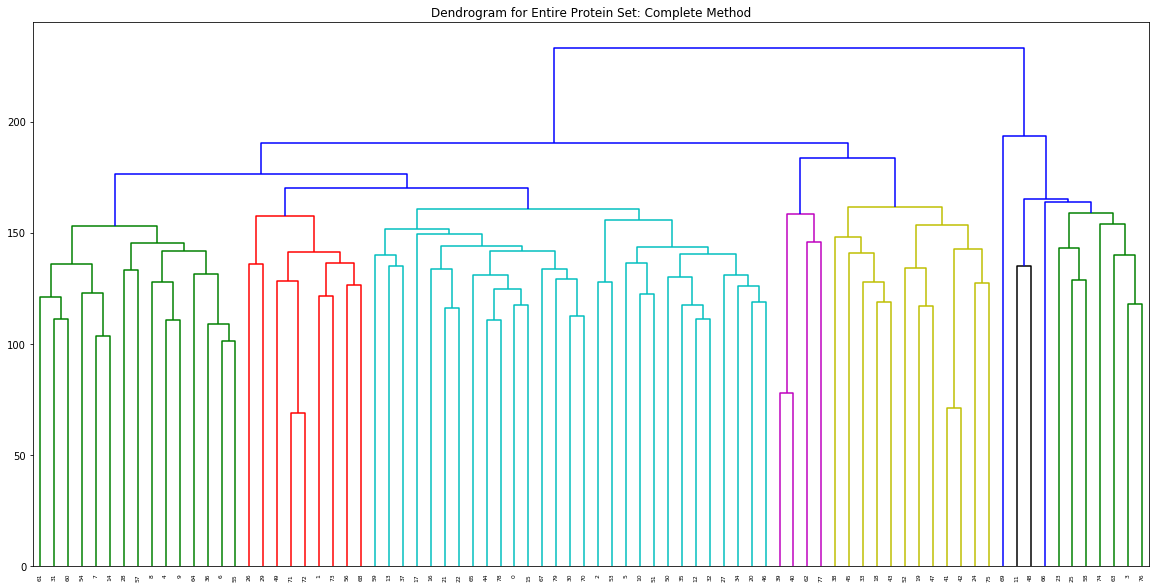

In [40]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete'))
plt.title("Dendrogram for Entire Protein Set: Complete Method")
plt.show()

In [41]:
compare_agg_clusters_complete(n_clusters, proteomes)

LINKAGE: COMPLETE

Adjusted Rand Index for k == 2: 0.01882827159233198
Silhouette Coefficient for k == 2: 0.036326022348114086


Adjusted Rand Index for k == 3: 0.081725948902606
Silhouette Coefficient for k == 3: 0.0383487996264661


Adjusted Rand Index for k == 4: 0.09654457424409223
Silhouette Coefficient for k == 4: 0.034087243575308665


Adjusted Rand Index for k == 5: 0.1211007024454475
Silhouette Coefficient for k == 5: 0.0473032947656148


Adjusted Rand Index for k == 6: 0.12285668209341204
Silhouette Coefficient for k == 6: 0.034732499120600016


Adjusted Rand Index for k == 7: 0.10073082460802898
Silhouette Coefficient for k == 7: 0.028884969012244844


Adjusted Rand Index for k == 10: 0.07538166711682165
Silhouette Coefficient for k == 10: 0.040063814907638


Adjusted Rand Index for k == 20: 0.05032369062455196
Silhouette Coefficient for k == 20: 0.019553294626437158




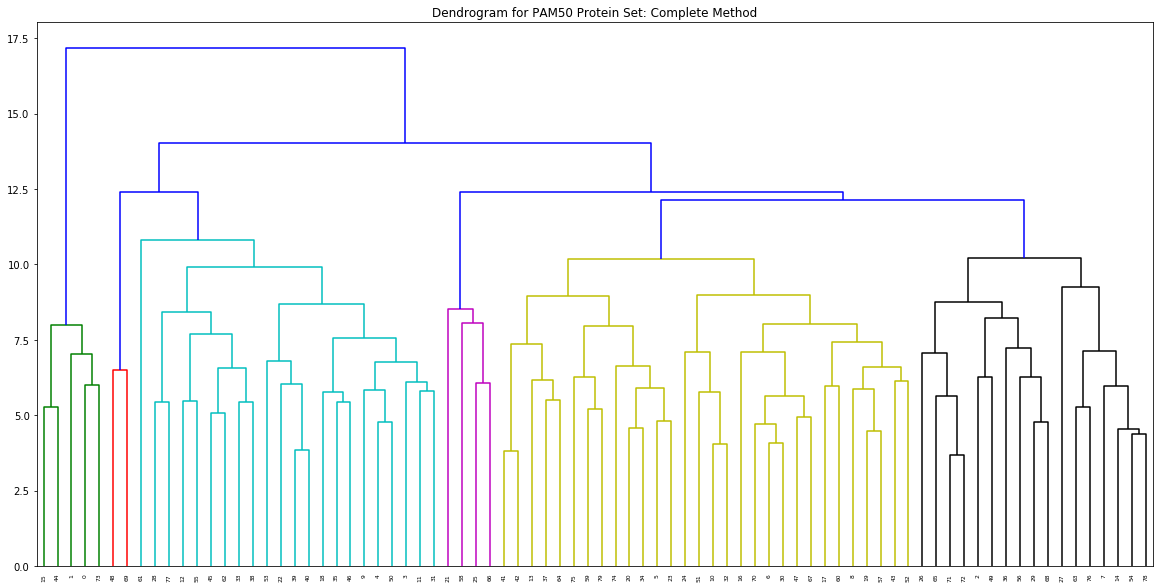

In [42]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std_p50, method='complete'))
plt.title("Dendrogram for PAM50 Protein Set: Complete Method")
plt.show()

In [43]:
compare_agg_clusters_complete(n_clusters, p50)

LINKAGE: COMPLETE

Adjusted Rand Index for k == 2: 0.03219715819609267
Silhouette Coefficient for k == 2: 0.17535798519474444


Adjusted Rand Index for k == 3: 0.1028089965686343
Silhouette Coefficient for k == 3: 0.10548146767861884


Adjusted Rand Index for k == 4: 0.27497341010114057
Silhouette Coefficient for k == 4: 0.10196715556425437


Adjusted Rand Index for k == 5: 0.26445682122664954
Silhouette Coefficient for k == 5: 0.09359251348176045


Adjusted Rand Index for k == 6: 0.26291736097243185
Silhouette Coefficient for k == 6: 0.09129458425169254


Adjusted Rand Index for k == 7: 0.33627564683307665
Silhouette Coefficient for k == 7: 0.12137250304789285


Adjusted Rand Index for k == 10: 0.31876753311589306
Silhouette Coefficient for k == 10: 0.1053497664121982


Adjusted Rand Index for k == 20: 0.1635827622617976
Silhouette Coefficient for k == 20: 0.07863886039777544




In [44]:
def compare_agg_clusters_average(k_list, data):
    print('LINKAGE: AVERAGE')
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = AgglomerativeClustering(linkage='average',
                                      affinity = 'cosine',
                                      n_clusters = k)
        clusterer.fit(data)
        
        print("Adjusted Rand Index for k == {}: {}".format(k, metrics.adjusted_rand_score(y, clusterer.labels_)))
        print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(data, clusterer.labels_)))
        print('\n')

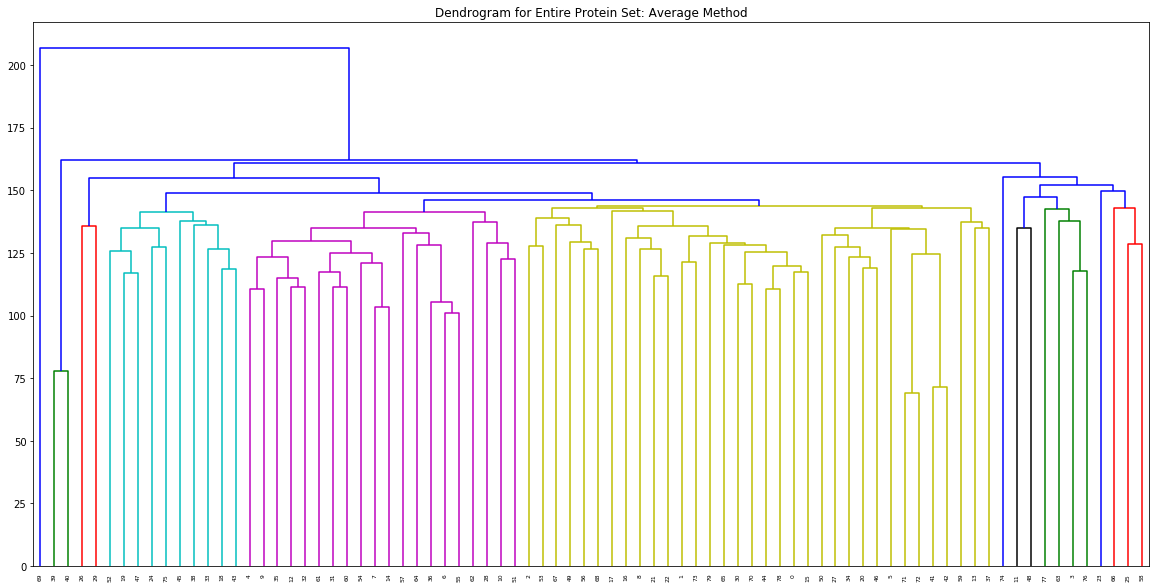

In [45]:
# Average linkage method
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='average'))
plt.title("Dendrogram for Entire Protein Set: Average Method")
plt.show()

In [46]:
compare_agg_clusters_average(n_clusters, proteomes)

LINKAGE: AVERAGE
Adjusted Rand Index for k == 2: 0.01915894171838923
Silhouette Coefficient for k == 2: 0.04694232176093669


Adjusted Rand Index for k == 3: 0.010140585388338341
Silhouette Coefficient for k == 3: 0.02072724166961008


Adjusted Rand Index for k == 4: 0.0031439142802147445
Silhouette Coefficient for k == 4: -0.004677567895603708


Adjusted Rand Index for k == 5: -0.0025492772080011926
Silhouette Coefficient for k == 5: -0.003085863699532307


Adjusted Rand Index for k == 6: 0.02114411574444133
Silhouette Coefficient for k == 6: 0.014680627106422603


Adjusted Rand Index for k == 7: 0.03711661996821657
Silhouette Coefficient for k == 7: 0.01587562843106927


Adjusted Rand Index for k == 10: 0.056694158318879556
Silhouette Coefficient for k == 10: 0.03907227831853678


Adjusted Rand Index for k == 20: 0.021790939611223945
Silhouette Coefficient for k == 20: 0.04274121817508556




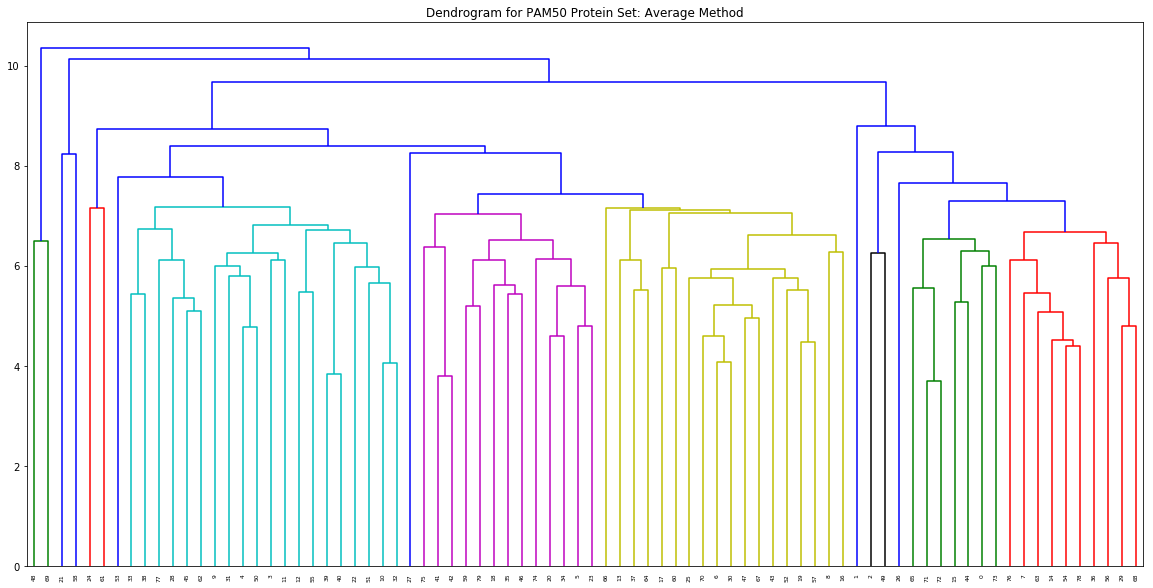

In [47]:
# Average linkage method
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std_p50, method='average'))
plt.title("Dendrogram for PAM50 Protein Set: Average Method")
plt.show()

In [48]:
compare_agg_clusters_average(n_clusters, p50)

LINKAGE: AVERAGE
Adjusted Rand Index for k == 2: 0.07885015706333294
Silhouette Coefficient for k == 2: 0.19588912716178963


Adjusted Rand Index for k == 3: 0.06608207311644225
Silhouette Coefficient for k == 3: 0.1354967553959093


Adjusted Rand Index for k == 4: 0.06427634797925433
Silhouette Coefficient for k == 4: 0.09057833223971644


Adjusted Rand Index for k == 5: 0.12549073052354848
Silhouette Coefficient for k == 5: 0.07089614568161455


Adjusted Rand Index for k == 6: 0.14272535400860592
Silhouette Coefficient for k == 6: 0.05319376129048694


Adjusted Rand Index for k == 7: 0.12987484853038805
Silhouette Coefficient for k == 7: 0.057153482655619384


Adjusted Rand Index for k == 10: 0.12313049616528103
Silhouette Coefficient for k == 10: 0.004972643894313433


Adjusted Rand Index for k == 20: 0.3139635271748624
Silhouette Coefficient for k == 20: 0.051374687712944914




In [49]:
def compare_agg_clusters_ward(k_list, data):
    print('LINKAGE: WARD')
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = AgglomerativeClustering(linkage='ward',
                                      affinity = 'euclidean',
                                      n_clusters = k)
        clusterer.fit(data)
        
        print("Adjusted Rand Index for k == {}: {}".format(k, metrics.adjusted_rand_score(y, clusterer.labels_)))
        print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(data, clusterer.labels_)))
        print('\n')

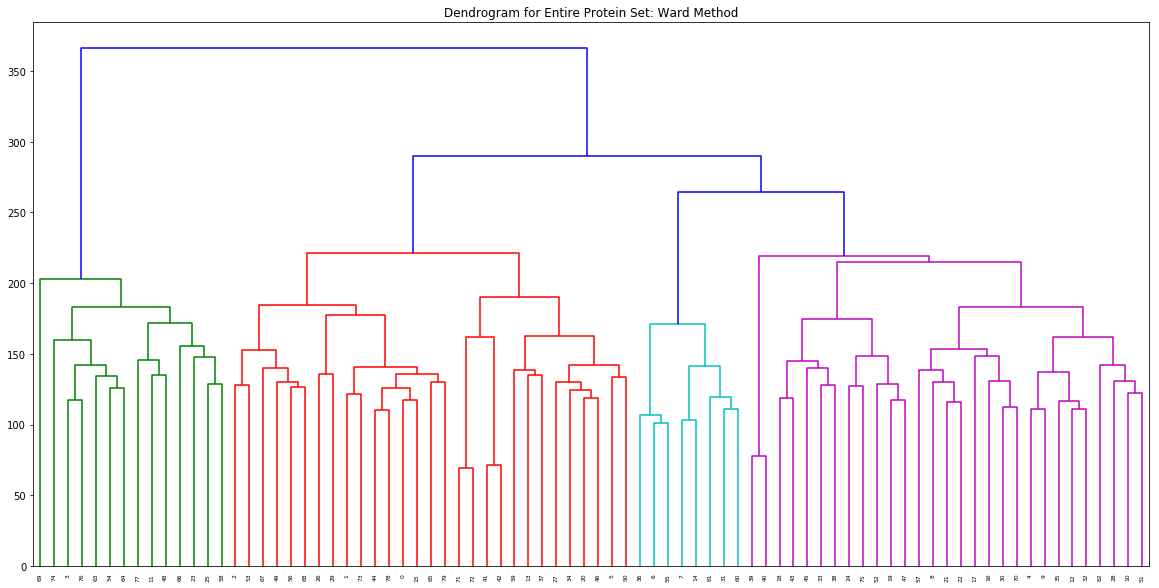

In [50]:
# Ward linkage method - proteomes
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='ward'))
plt.title("Dendrogram for Entire Protein Set: Ward Method")
plt.show()

In [51]:
# ward linkage - proteomes
compare_agg_clusters_ward(n_clusters, proteomes)

LINKAGE: WARD
Adjusted Rand Index for k == 2: 0.00854030663787393
Silhouette Coefficient for k == 2: 0.12238898945002905


Adjusted Rand Index for k == 3: 0.009002129424800772
Silhouette Coefficient for k == 3: 0.05345751482168411


Adjusted Rand Index for k == 4: 0.15560093604029732
Silhouette Coefficient for k == 4: 0.050815226209797414


Adjusted Rand Index for k == 5: 0.13836227057422723
Silhouette Coefficient for k == 5: 0.05406624780157919


Adjusted Rand Index for k == 6: 0.17828846727145725
Silhouette Coefficient for k == 6: 0.05718212494241427


Adjusted Rand Index for k == 7: 0.19501558751113796
Silhouette Coefficient for k == 7: 0.05601347081610684


Adjusted Rand Index for k == 10: 0.1445786877771791
Silhouette Coefficient for k == 10: 0.05393717218553253


Adjusted Rand Index for k == 20: 0.09045189926526992
Silhouette Coefficient for k == 20: 0.06667414901779947




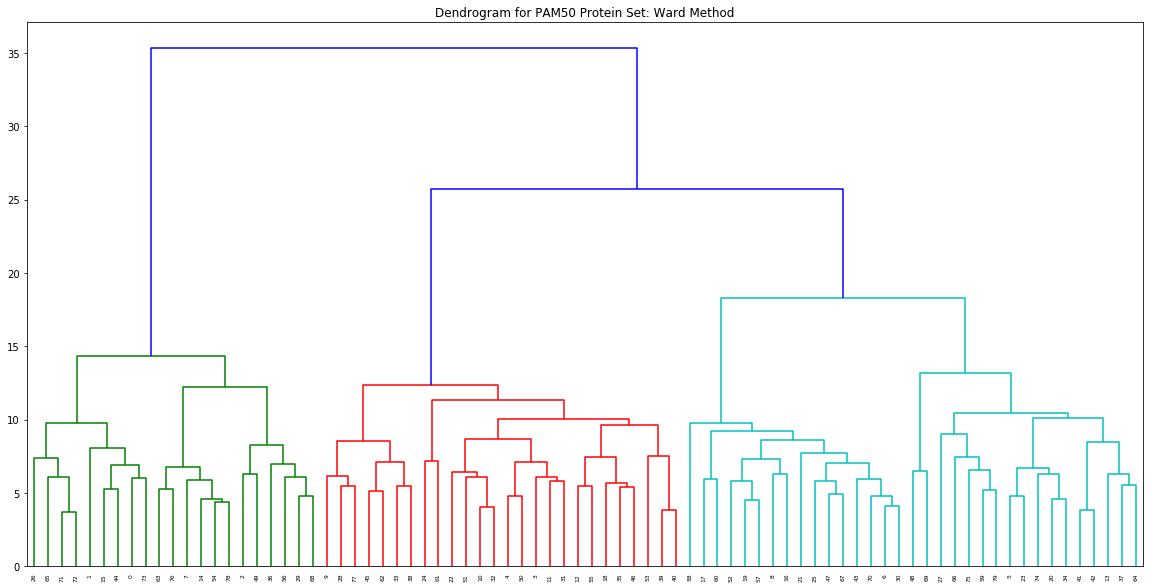

In [52]:
# Ward linkage method - PAM50
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std_p50, method='ward'))
plt.title("Dendrogram for PAM50 Protein Set: Ward Method")
plt.show()

In [53]:
# ward linkage - PAM50
compare_agg_clusters_ward(n_clusters, p50)

LINKAGE: WARD
Adjusted Rand Index for k == 2: 0.29351548824111423
Silhouette Coefficient for k == 2: 0.20936110416611275


Adjusted Rand Index for k == 3: 0.2994298333358982
Silhouette Coefficient for k == 3: 0.15704536746919517


Adjusted Rand Index for k == 4: 0.3643807858179961
Silhouette Coefficient for k == 4: 0.1414250997405226


Adjusted Rand Index for k == 5: 0.326797538913776
Silhouette Coefficient for k == 5: 0.12416839252246628


Adjusted Rand Index for k == 6: 0.32143635501198675
Silhouette Coefficient for k == 6: 0.11659471071783453


Adjusted Rand Index for k == 7: 0.28562077559372
Silhouette Coefficient for k == 7: 0.10554494586346228


Adjusted Rand Index for k == 10: 0.2175966152635346
Silhouette Coefficient for k == 10: 0.1029641007173792


Adjusted Rand Index for k == 20: 0.1283619185329071
Silhouette Coefficient for k == 20: 0.11589222978416772




Looking at the dendrograms and agglomerative clustering, only the ward method seemed to do a good job of grouping the patients together. The best solution occurred at k=4 for the PAM50 set, with an ARI of 0.36 and silhouette coefficient of 0.14.  

### GMM clustering

In [54]:
# diag covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'diag', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'diag', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'diag', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std)

gmm_cluster5 = GaussianMixture(n_components=5, covariance_type = 'diag', random_state=123)
clusters5 = gmm_cluster5.fit_predict(X_std)

print("GMM Clustering for Entire Protein Set: Diag Covariance\n")
print("Adjusted Rand Index for k == 2: {}".format(metrics.adjusted_rand_score(y, clusters2)))
print("Silhoutte Coefficient for k == 2: {}".format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 3: {}".format(metrics.adjusted_rand_score(y, clusters3)))
print("Silhoutte Coefficient for k == 3: {}".format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 4: {}".format(metrics.adjusted_rand_score(y, clusters4)))
print("Silhoutte Coefficient for k == 4: {}".format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 5: {}".format(metrics.adjusted_rand_score(y, clusters5)))
print("Silhoutte Coefficient for k == 5: {}".format(metrics.silhouette_score(X_std, clusters5, metric='euclidean')))

GMM Clustering for Entire Protein Set: Diag Covariance

Adjusted Rand Index for k == 2: 0.00854030663787393
Silhoutte Coefficient for k == 2: 0.09808760668392259


Adjusted Rand Index for k == 3: 0.05178058406633451
Silhoutte Coefficient for k == 3: 0.056627089553069276


Adjusted Rand Index for k == 4: 0.10972918675747627
Silhoutte Coefficient for k == 4: 0.036908025201324676


Adjusted Rand Index for k == 5: 0.09685036181433614
Silhoutte Coefficient for k == 5: 0.02270862522899877


In [55]:
# diag covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'diag', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std_p50)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'diag', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std_p50)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'diag', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std_p50)

gmm_cluster5 = GaussianMixture(n_components=5, covariance_type = 'diag', random_state=123)
clusters5 = gmm_cluster5.fit_predict(X_std_p50)

print("GMM Clustering for PAM50 Protein Set: Diag Covariance\n")
print("Adjusted Rand Index for k == 2: {}".format(metrics.adjusted_rand_score(y, clusters2)))
print("Silhoutte Coefficient for k == 2: {}".format(metrics.silhouette_score(X_std_p50, clusters2, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 3: {}".format(metrics.adjusted_rand_score(y, clusters3)))
print("Silhoutte Coefficient for k == 3: {}".format(metrics.silhouette_score(X_std_p50, clusters3, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 4: {}".format(metrics.adjusted_rand_score(y, clusters4)))
print("Silhoutte Coefficient for k == 4: {}".format(metrics.silhouette_score(X_std_p50, clusters4, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 5: {}".format(metrics.adjusted_rand_score(y, clusters5)))
print("Silhoutte Coefficient for k == 5: {}".format(metrics.silhouette_score(X_std_p50, clusters5, metric='euclidean')))

GMM Clustering for PAM50 Protein Set: Diag Covariance

Adjusted Rand Index for k == 2: 0.19773407644844881
Silhoutte Coefficient for k == 2: 0.16107149352185418


Adjusted Rand Index for k == 3: 0.4126641974100625
Silhoutte Coefficient for k == 3: 0.1438325868644205


Adjusted Rand Index for k == 4: 0.4063682604910544
Silhoutte Coefficient for k == 4: 0.10464462067796303


Adjusted Rand Index for k == 5: 0.3387595917185464
Silhoutte Coefficient for k == 5: 0.09398192815343409


In [56]:
# spherical covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'spherical', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'spherical', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'spherical', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std)

gmm_cluster5 = GaussianMixture(n_components=5, covariance_type = 'spherical', random_state=123)
clusters5 = gmm_cluster5.fit_predict(X_std)

print("GMM Clustering for Entire Protein Set: Spherical Covariance\n")
print("Adjusted Rand Index for k == 2: {}".format(metrics.adjusted_rand_score(y, clusters2)))
print("Silhoutte Coefficient for k == 2: {}".format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 3: {}".format(metrics.adjusted_rand_score(y, clusters3)))
print("Silhoutte Coefficient for k == 3: {}".format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 4: {}".format(metrics.adjusted_rand_score(y, clusters4)))
print("Silhoutte Coefficient for k == 4: {}".format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 5: {}".format(metrics.adjusted_rand_score(y, clusters5)))
print("Silhoutte Coefficient for k == 5: {}".format(metrics.silhouette_score(X_std, clusters5, metric='euclidean')))

GMM Clustering for Entire Protein Set: Spherical Covariance

Adjusted Rand Index for k == 2: 0.00854030663787393
Silhoutte Coefficient for k == 2: 0.09808760668392259


Adjusted Rand Index for k == 3: 0.04934989718955353
Silhoutte Coefficient for k == 3: 0.04858869287384594


Adjusted Rand Index for k == 4: 0.10972918675747627
Silhoutte Coefficient for k == 4: 0.036908025201324676


Adjusted Rand Index for k == 5: 0.09884968555865696
Silhoutte Coefficient for k == 5: 0.026240559468702063


In [57]:
# spherical covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'spherical', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std_p50)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'spherical', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std_p50)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'spherical', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std_p50)

gmm_cluster5 = GaussianMixture(n_components=5, covariance_type = 'spherical', random_state=123)
clusters5 = gmm_cluster5.fit_predict(X_std_p50)

print("GMM Clustering for PAM50 Protein Set: Spherical Covariance\n")
print("Adjusted Rand Index for k == 2: {}".format(metrics.adjusted_rand_score(y, clusters2)))
print("Silhoutte Coefficient for k == 2: {}".format(metrics.silhouette_score(X_std_p50, clusters2, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 3: {}".format(metrics.adjusted_rand_score(y, clusters3)))
print("Silhoutte Coefficient for k == 3: {}".format(metrics.silhouette_score(X_std_p50, clusters3, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 4: {}".format(metrics.adjusted_rand_score(y, clusters4)))
print("Silhoutte Coefficient for k == 4: {}".format(metrics.silhouette_score(X_std_p50, clusters4, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 5: {}".format(metrics.adjusted_rand_score(y, clusters5)))
print("Silhoutte Coefficient for k == 5: {}".format(metrics.silhouette_score(X_std_p50, clusters5, metric='euclidean')))

GMM Clustering for PAM50 Protein Set: Spherical Covariance

Adjusted Rand Index for k == 2: 0.20187658231645125
Silhoutte Coefficient for k == 2: 0.16086045553329004


Adjusted Rand Index for k == 3: 0.42370424761574277
Silhoutte Coefficient for k == 3: 0.14385617504136966


Adjusted Rand Index for k == 4: 0.43187513156727747
Silhoutte Coefficient for k == 4: 0.14196077481513075


Adjusted Rand Index for k == 5: 0.3686592824076147
Silhoutte Coefficient for k == 5: 0.10374503103795663


Again the scoring for the entire protein set was pretty low across the board. For the PAM50 set optimal solution was at k=4 using the spherical covariance with an ARI of 0.43 and silhouette coefficient of 0.14. 

## Discussion

Applying the three different unsupervised clustering methods to the data, it appears that four to five clusters was achieving the best outcome on average for both sets. The scores for the entire protein set were all pretty low, suggesting to me that there is quite a bit of difference in the protein expression patterns between the 80 patients and that there was difficulty for the algorithms grouping the clusters together. This was also evident when we got such clearly defined results while performing the dimensionality reduction techniques. Examining over 11,000 different proteins it would make sense that there would be significant differences between the patients. Looking at the PAM50 proteins, when k was set to four seemed to be the optimal solution overall which is in line with what we would expect as the PAM50 screening normally identifies four different sub-types.

Because we had so many features in the proteomes dataset, we got to see the power of the dimensionality reduction techniques which were able to take all of those features and separate them out in a two-dimensional visualization. Clustering algorithms are a good way to find similarities between the observations in your data, however for the reasons mentioned above it is understandable that with this data we had a difficult time getting good clusters. Perhaps if we had similar data for many more breast cancer patients we would start to get better separation and gain more insights. Additionally, it would be really intriguing to identify a multitude of candidate genes, in addition to the PAM50 genes, and see how these same clustering algorithms perform. Examining over 11,000 genes was likely too much, but if you could focus that down to around 500 there may be some interesting insights to be gained.   

## Future Steps

We've seen from the results here that examining such a large portion of a patient's proteome is not a reliable method of separating patients into defined sub-classes for treatment purposes. As medicine advances and becomes more individualized, perhaps data such as this could lead to very precise and persoanlized treatment for each individual, however as it currently stands developing drugs and treatments for single individuals is neither feasible nor economically viable. I do believe however that there is a sweet spot between the two that is attainable by today's technology. This is evident when we look at the PAM50 clustering results and saw higher scoring at four clusters. There is clearly some underlining similarities and differences between patients that should have clinical utility. As a future step in utilizing protein data, I propose that data from more patients be obtained and also that we expand upon the PAM50 protein list to some extant. Increasing the amount of data available for analysis could be key to developing more effective treatments and ultimately improving patient outcomes.   